In [36]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from models.geoencoder import LoadGeoEncoderModel
from models import configs
from models.configs import models_configs, LoadData
from torch.utils.data import DataLoader
from skimage import measure
from tqdm import tqdm
import time
configs.POINTS_CLOUD_PADDING_VALUE=-0.2
device = "cuda" if torch.cuda.is_available() else "cpu"

In [37]:
configs_m = models_configs()
filebase = configs_m["GeoEncoder"]["filebase"]
model_args = configs_m["GeoEncoder"]["model_args"]
print(f"\n\nGeoEncoder Filebase: {filebase}, model_args:")
print(model_args)
geo_encoder, sdf_NN = LoadGeoEncoderModel(
    filebase, model_args)




GeoEncoder Filebase: /work/hdd/bdsy/qibang/repository_Wbdsy/GeoSDF2D/models/saved_weights/geoencoder_outc256_latentdim256_fpsfps, model_args:
{'out_c': 256, 'latent_d': 256, 'width': 128, 'n_point': 128, 'n_sample': 8, 'radius': 0.2, 'd_hidden': [128, 128], 'num_heads': 4, 'cross_attn_layers': 1, 'self_attn_layers': 3, 'pc_padding_val': -0.2, 'd_hidden_sdfnn': [128, 128], 'latent_d_sdfnn': 256, 'in_c_sdfnn': 256, 'fps_method': 'fps'}
Total number of parameters of Geo encoder: 1132160, 1132160 of which are trainable
Total number of parameters of SDF NN: 4203517, 4203517 of which are trainable


In [38]:
train_dataset, test_dataset, grid_coor, sdf_inv_scaler, _ = LoadData(geoencoder=True)

x_grids = grid_coor[:, 0].reshape(120, -1).cpu().numpy()
y_grids = grid_coor[:, 1].reshape(120, -1).cpu().numpy()
grid_coor = grid_coor.to(device)

In [39]:

def predict(data, geo_encoder, sdf_NN, grid_coor):
    sd_pred = []
    sd_true = []
    geo_encoder = geo_encoder.to(device)
    sdf_NN = sdf_NN.to(device)
    geo_encoder.eval()
    sdf_NN.eval()
    with torch.no_grad():
        if isinstance(data, DataLoader):
            for data in tqdm(data, desc="Predicting"):
                pc = data[0].to(device)
                SDF = data[2].to(device)
                latents = geo_encoder(pc)
                sdf_pred = sdf_NN(grid_coor, latents)
                sd_pred.append(sdf_pred.detach().cpu().numpy())
                sd_true.append(SDF.detach().cpu().numpy())
            sd_pred = np.vstack(sd_pred)
            sd_true = np.vstack(sd_true)
        else:
            pc = data[0].to(device)
            SDF = data[2].to(device)
            latents = geo_encoder(pc)
            sdf_pred = sdf_NN(grid_coor, latents)
            sd_pred.append(sdf_pred.detach().cpu().numpy())
            sd_true.append(SDF.detach().cpu().numpy())
            sd_pred = np.vstack(sd_pred)
            sd_true = np.vstack(sd_true)
    return sd_pred, sd_true


def plot_geo_from_sdf(sdf, ax, line_style, label):
    geo = measure.find_contours(
        sdf, 0, positive_orientation='high')
    for c, contour in enumerate(geo):
        contour = contour*1.2/119-0.1
        if c == 0:
            ax.plot(contour[:, 1], contour[:, 0], line_style,
                    linewidth=2, label=label)
        else:
            ax.plot(contour[:, 1], contour[:, 0], line_style, linewidth=2)

    # ax.set_aspect("equal")

In [40]:

time_start=time.time()
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)
sd_pred, sd_true = predict(test_loader, geo_encoder, sdf_NN, grid_coor)
sd_pred_inv = sdf_inv_scaler(sd_pred)
sd_true_inv = sdf_inv_scaler(sd_true)
time_end=time.time()
print(f"Time taken to predict one sample: {(time_end-time_start)/len(sd_pred):.2e} seconds")

Predicting:   0%|          | 0/15 [00:00<?, ?it/s]

Predicting: 100%|██████████| 15/15 [00:07<00:00,  1.98it/s]


Time taken to predict one sample: 5.57e-04 seconds


Mean L2 error of SDF: 0.026484372094273567, std: 0.007305969949811697
Index 0 for Best: 4257, error: 0.013510904274880886
Index 1 for 32% percentile: 13533, error: 0.022826461121439934
Index 2 for 64% percentile: 9578, error: 0.02765209600329399
Index 3 for 97% percentile: 3409, error: 0.04001692309975624


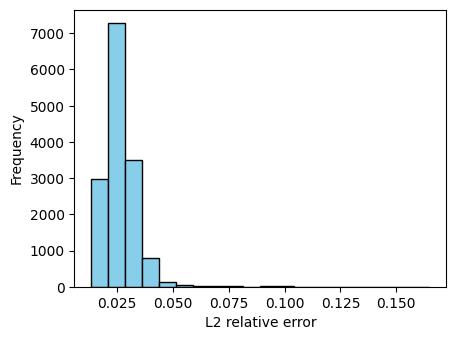

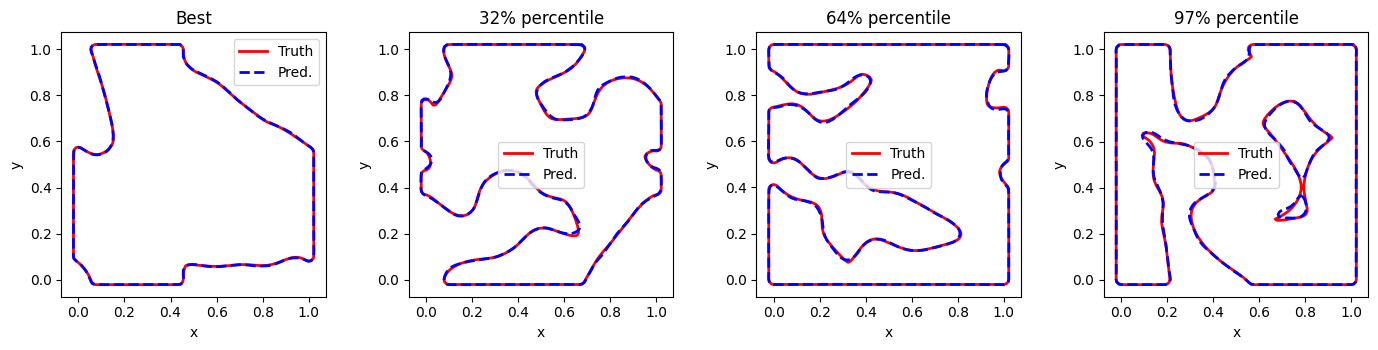

In [41]:
error_s = np.linalg.norm(sd_pred_inv-sd_true_inv, axis=1) / \
        np.linalg.norm(sd_true_inv, axis=1)
mean, std = np.mean(error_s), np.std(error_s)
fig = plt.figure(figsize=(4.8, 3.6))
ax = plt.subplot(1, 1, 1)

_ = ax.hist(error_s, bins=20, color="skyblue", edgecolor="black")
ax.set_xlabel("L2 relative error")
ax.set_ylabel("Frequency")

print(f"Mean L2 error of SDF: {mean}, std: {std}")

sort_idx = np.argsort(error_s)
titles = ["Best", "32% percentile", "64% percentile", "97% percentile"]
min_index = sort_idx[0]
max_index = sort_idx[int(len(sort_idx)*0.97-1)]
median_index = sort_idx[int(len(sort_idx) * 0.32)]
median_index2 = sort_idx[int(len(sort_idx) * 0.64)]
indices = np.array([min_index, median_index, median_index2, max_index])
for i in range(len(indices)):
    print(
        f"Index {i} for {titles[i]}: {indices[i]}, error: {error_s[indices[i]]}")

nr, nc = 1, 4
fig = plt.figure(figsize=(nc*3.6, nr*3.6))
for i, index in enumerate(indices):
    ax = plt.subplot(nr, nc, i+1)
    sd_pred_i = sd_pred[index].reshape(x_grids.shape)
    sd_true_i = sd_true[index].reshape(x_grids.shape)
    plot_geo_from_sdf(sd_true_i, ax, 'r', label="Truth")
    plot_geo_from_sdf(sd_pred_i, ax, '--b', label="Pred.")
    ax.legend()
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_aspect("equal")
    ax.set_title(f"{titles[i]}")

    plt.tight_layout()



In [42]:
# Extract data from test_dataset
test_data = test_dataset[min_index]
pc_padded= test_data[0]
test_data_padded = (pc_padded[None], test_data[1][None], test_data[2][None])
sd_pred, sd_true = predict(test_data_padded, geo_encoder, sdf_NN, grid_coor)
sd_pred_padded = sdf_inv_scaler(sd_pred[0]).reshape(x_grids.shape)
sd_true = sdf_inv_scaler(sd_true[0]).reshape(x_grids.shape)
true_geo = measure.find_contours(sd_true, 0, positive_orientation='high')
pred_padded_geo = measure.find_contours(
    sd_pred_padded, 0, positive_orientation='high')



In [43]:

pc_padded_shuffle= pc_padded[torch.randperm(pc_padded.size(0))]
latents = geo_encoder(pc_padded_shuffle[None].to(device))
sdf_pred = sdf_NN(grid_coor, latents)
sdf_pred = sdf_inv_scaler(sdf_pred.detach().cpu().numpy())
sd_pred_paaded_shuffle = sdf_pred.reshape(x_grids.shape)

In [44]:
idx_pad = np.where(test_data[0][:, 0] == configs.POINTS_CLOUD_PADDING_VALUE)[0][0]
pc_no_padded = test_data[0][:idx_pad]
latents = geo_encoder(pc_no_padded[None].to(device))
sdf_pred = sdf_NN(grid_coor, latents)
sdf_pred = sdf_inv_scaler(sdf_pred.detach().cpu().numpy())
sd_pred_no_padded = sdf_pred.reshape(x_grids.shape)



In [45]:

pc_reduced = pc_no_padded[::2]
latents = geo_encoder(pc_reduced[None].to(device))
sdf_pred = sdf_NN(grid_coor, latents)
sdf_pred = sdf_inv_scaler(sdf_pred.detach().cpu().numpy())
sd_pred_reduced = sdf_pred.reshape(x_grids.shape)



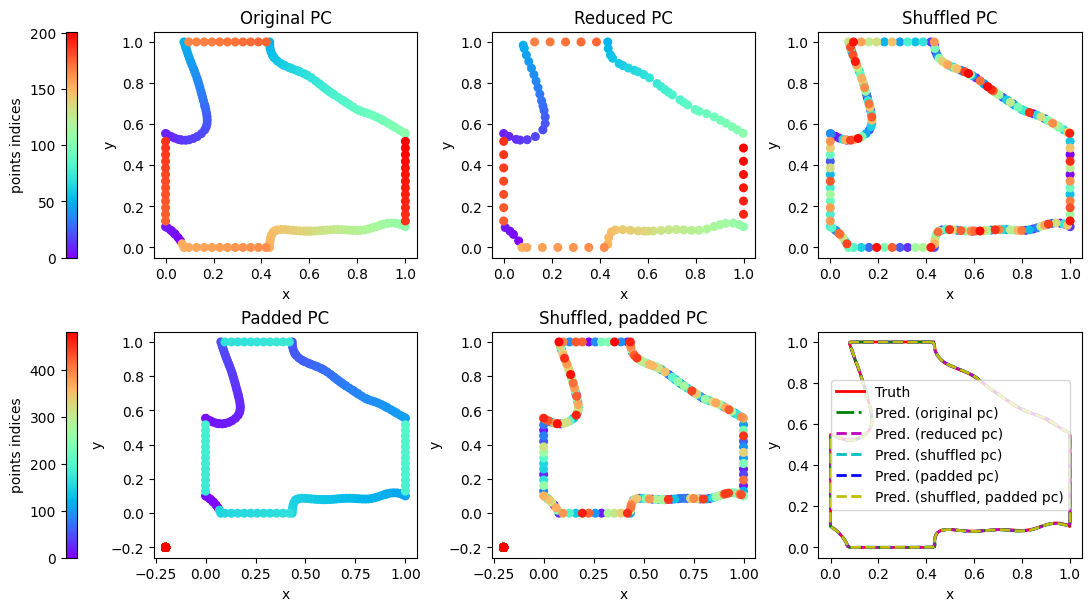

In [46]:
pc_shuffuled = pc_no_padded[torch.randperm(pc_no_padded.size(0))]
latents = geo_encoder(pc_shuffuled[None].to(device))
sdf_pred = sdf_NN(grid_coor, latents)
sdf_pred = sdf_inv_scaler(sdf_pred.detach().cpu().numpy())
sd_pred_shuffled = sdf_pred.reshape(x_grids.shape)

nc, nr = 3, 2
p_size = 30
fig, axes = plt.subplots(nr, nc, figsize=(
    nc*3.6, nr*3), constrained_layout=True)

ax = axes[0, 0]
c = ax.scatter(pc_no_padded[:, 0], pc_no_padded[:, 1],
               s=p_size, c=range(len(pc_no_padded)), cmap="rainbow")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Original PC")
fig.colorbar(c, ax=ax, location='left', label="points indices")

ax = axes[0,1]
_ = ax.scatter(pc_reduced[:, 0], pc_reduced[:, 1], s=p_size,
               c=range(len(pc_reduced)), cmap="rainbow")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Reduced PC")
ax = axes[0,2]
_ = ax.scatter(pc_shuffuled[:, 0], pc_shuffuled[:, 1],
               s=p_size, c=range(len(pc_shuffuled)), cmap="rainbow")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Shuffled PC")

ax = axes[1,0]
c = ax.scatter(pc_padded[:, 0], pc_padded[:, 1],
               s=p_size, c=range(len(pc_padded)), cmap="rainbow")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Padded PC")
fig.colorbar(c, ax=ax, location='left', label="points indices")


ax = axes[1,1]
_ = ax.scatter(pc_padded_shuffle[:, 0], pc_padded_shuffle[:, 1],
               s=p_size, c=range(len(pc_padded)), cmap="rainbow")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Shuffled, padded PC")


ax = axes[1,2]
plot_geo_from_sdf(sd_true, ax, 'r', label="Truth")
plot_geo_from_sdf(sd_pred_no_padded, ax, '-.g', label="Pred. (original pc)")
plot_geo_from_sdf(sd_pred_reduced, ax, '--m', label="Pred. (reduced pc)")
plot_geo_from_sdf(sd_pred_shuffled, ax, '--c', label="Pred. (shuffled pc)")
plot_geo_from_sdf(sd_pred_padded, ax, '--b', label="Pred. (padded pc)")
plot_geo_from_sdf(sd_pred_paaded_shuffle, ax, '--y', label="Pred. (shuffled, padded pc)")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.legend()

In [47]:
print(f"Number of points in original PC: {len(pc_no_padded)}")
print(f"Number of points in reduced PC: {len(pc_reduced)}")
print(f"Number of points in shuffled PC: {len(pc_shuffuled)}")
print(f"Number of points in padded PC: {len(test_data[0])}")

Number of points in original PC: 202
Number of points in reduced PC: 101
Number of points in shuffled PC: 202
Number of points in padded PC: 482
